In [1]:
import pandas as pd
import numpy as np
from pandas import ExcelWriter
import xlsxwriter


In [2]:
#Path hacia la base de datos de producto por laminador.
path=r'C:\Users\JBELTRAN\Documents\Python_fundamentals\Proyecto_final\Historial produccion2.xls'

#Abreviación de laminadores
#CL3 > Celaya - Laminador 3
#CL2 > Celaya - Laminador 2
#CL1 > Celaya - Laminador 1
#CL0 > Celaya - Laminador 0
#SL1 > Saltillo - Laminación
#RL1 > Ramos - SFM
#RL2 > Ramos - Molino 2

#DF de variables por equipo
dict_1={
    "Laminador":["CL3","CL2","CL1","CL0","SL1","RL1","RL2"], 
    "PC":[6,6,4.5,13,10.32,5.81,4.98],
    "inferior":[3.6,3.6,4,8,6,2,2],
    "superior":[7,7,7,17,16,8.5,8.5]
}
variables=pd.DataFrame(dict_1)
print(variables)

  Laminador     PC  inferior  superior
0       CL3   6.00       3.6       7.0
1       CL2   6.00       3.6       7.0
2       CL1   4.50       4.0       7.0
3       CL0  13.00       8.0      17.0
4       SL1  10.32       6.0      16.0
5       RL1   5.81       2.0       8.5
6       RL2   4.98       2.0       8.5


In [3]:
def func_nom(laminador):
    Prod=laminador+'_Prod'#Referencia a la columna de tipo de producto del laminador en la BDD.
    Con=laminador+'_Con' #Referencia a la columna de consumo del laminador en la BDD.
    inferior=float(variables[variables["Laminador"]==laminador]["inferior"].values) #limite inferior
    superior=float(variables[variables["Laminador"]==laminador]["superior"].values) #Limite superior
    PC=float(variables[variables["Laminador"]==laminador]["PC"].values) #Potencia contratada
    
    df = pd.read_excel(path, 'Datos', usecols=['Hora',Prod,Con]) #Lectura de base de datos
    Productos=df[Prod].dropna().unique() #Productos del laminador
    Horas=df['Hora'].dropna().unique() #Horas de consumo diarias

    print("El laminador seleccionado es: ",laminador,"\n\nLos productos de este laminador son: ",Productos,"\n")
    print("Limite inferior de cunsumo en operación: ",inferior,"MWh\nLimite superior de cunsumo en operación: ",superior,"MWh\nPotencia contratada: ",PC," MWh\n")

    print("Promedio de consumo por tipo de producto(MWh): \n\n",df.groupby([Prod])[Con].mean().reset_index())

    df2= pd.DataFrame(columns=Productos, index=Horas) #Creación de dataframe de nominación
    df3= pd.DataFrame(columns=Productos, index=Horas) #Creación de dataframe de MAPE
    for d in Productos:
        for h in Horas:
            dif=500 #Valor inicial del KPI "MAPE".
            mat=df.query('{0} == @d and Hora ==  @h'.format(Prod))
            nom=0
            for i in range(1,200,1): #Iteración de la nominación (MWh), nominación (i) multiplicada por 10 para fijar steps en decimales (0.1 MW).
                suma=0
                c=0 #Contador
                for consumo in mat[Con]: #Iteración por hora de consumo.
                    if consumo>inferior and consumo<superior:
                        suma += abs(consumo-i/10)/PC #Calculo del KPI "MAPE" para cada hora e iteración de la nominación
                        c += 1
                if c!=0:
                    if suma/c < dif: #Comparación del MAPE con el valor actual de nominación vs MAPE minimo encontrado.
                        dif=suma/c
                        nom=i/10
            df2.loc[h,d] = nom #Registro del valor de nominación óptima para la hora y producto.
            df3.loc[h,d] = dif #Registro del valor MAPE minimo (con la nominación óptima) para la hora y producto.

    print('\nNominación optima por hora y producto laminado (MWh): \n')
    print(df2)
    print('\nMAPE minimo por hora y producto laminado (%): \n')
    print(df3)
    
    #Se crean el archivo excel de resultados y se añaden las hojas de Nominación y MAPE
    writer = pd.ExcelWriter(r'C:\Users\JBELTRAN\Documents\Python_fundamentals\Proyecto_final\{0}_Resultados_nom.xlsx'.format(laminador), engine='xlsxwriter')
    df2.to_excel(writer, sheet_name='NOM')
    df3.to_excel(writer, sheet_name='MAPE')
    

    #Creación de la grafica
    graf=df.groupby([Prod])[Con].mean().plot.bar(xlabel='Producto',ylabel="MWh",figsize=(10,10),color="purple")
    print("\nGrafica del consumo promedio por tipo de producto (MWh): \n\n",graf)
    fig=graf.get_figure()
    fig.savefig(r'C:\Users\JBELTRAN\Documents\Python_fundamentals\Proyecto_final\{0}_Plot_consumo.jpg'.format(laminador))
    
    #Escritura de la grafica al archivo excel de resultados
    pd.DataFrame({}).to_excel(writer, sheet_name='Imagenes')
    worksheet = writer.sheets['Imagenes']
    worksheet.insert_image('A1', r'C:\Users\JBELTRAN\Documents\Python_fundamentals\Proyecto_final\{0}_Plot_consumo.jpg'.format(laminador))
    writer.save()

El laminador seleccionado es:  RL1 

Los productos de este laminador son:  ['CANAL' 'MULTIPLE' 'VIGA S' 'SOLERA' 'ANGULO' 'VIGA R'] 

Limite inferior de cunsumo en operación:  2.0 MWh
Limite superior de cunsumo en operación:  8.5 MWh
Potencia contratada:  5.81  MWh

Promedio de consumo por tipo de producto(MWh): 

    RL1_Prod   RL1_Con
0    ANGULO  3.286537
1     CANAL  3.708911
2  MULTIPLE  2.388957
3    SOLERA  3.074131
4    VIGA R  3.816960
5    VIGA S  3.784309

Nominación optima por hora y producto laminado (MWh): 

   CANAL MULTIPLE VIGA S SOLERA ANGULO VIGA R
1    4.9      3.9    5.5      4    3.9    4.6
2    4.5      3.9      5    3.7    4.4    4.5
3    4.7      4.1    5.3    3.2    4.1    4.8
4    4.7        4    4.8    3.7      4    4.9
5    4.7      3.9    4.6    3.9      4    4.5
6    4.4      4.2    5.1    3.5      4    4.6
7    4.5      3.9      5    3.7    3.8    4.7
8    4.5      3.8    4.7    3.9    3.7    4.8
9    4.4      3.9    4.4    3.5    3.8    4.8
10   4.3    

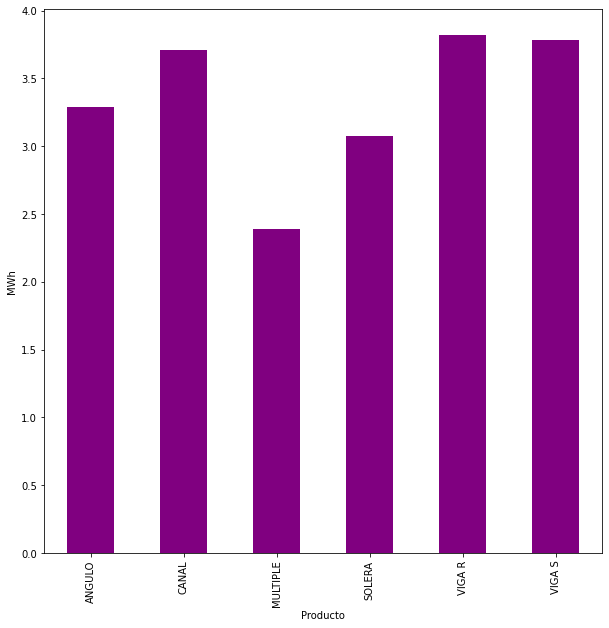

In [7]:
func_nom("RL1")